# Deep-embedded Clustering + Fully connected layer Classifation of non-mass lesions


## Results: 
## Improved AUC in optimized low-dimensional (LD) space compared to original high-dimensional (HD) space

## 1) Read original Datasets

In [1]:
import sys
import os
sys.path.insert(0,'Z:/Cristina/Section3/NME_DEC')

import mxnet as mx
import numpy as np
import pandas as pd

from utilities import *
import data
import model
from autoencoder import AutoEncoderModel
from solver import Solver, Monitor
import logging

from sklearn.manifold import TSNE
from utilities import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import sklearn.neighbors 
import matplotlib.patches as mpatches
from sklearn.utils.linear_assignment_ import linear_assignment

try:
   import cPickle as pickle
except:
   import pickle
import gzip

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

#####################################################
## 1) read in the datasets both all NME (to do pretraining)
NME_nxgraphs = r'Z:\Cristina\Section3\breast_MR_NME_biological\NMEs_SER_nxgmetrics'
    
allNMEs_dynamic = pd.read_csv(os.path.join(NME_nxgraphs,'dyn_roi_records_allNMEs_descStats.csv'), index_col=0)
   
allNMEs_morphology = pd.read_csv(os.path.join(NME_nxgraphs,'morpho_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_texture = pd.read_csv(os.path.join(NME_nxgraphs,'text_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_stage1 = pd.read_csv(os.path.join(NME_nxgraphs,'stage1_roi_records_allNMEs_descStats.csv'), index_col=0)

# to load SERw matrices for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGdatafeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    nxGdatafeatures = pickle.load(fin)

# to load discrall_dict dict for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGnormfeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    discrall_dict_allNMEs = pickle.load(fin)         

allNME_featurenames = pd.read_csv(os.path.join(NME_nxgraphs,'named_nxGnormfeatures_allNMEs_descStats.csv'), index_col=0)

#########
# shape inputs    
nxGdiscfeatures = discrall_dict_allNMEs   
print('Loading {} all nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

print('dynamic: {} leasions with features of size = {}'.format(allNMEs_dynamic.shape[0], allNMEs_dynamic.shape[1]))

print('morphology: {} leasions with features of size = {}'.format(allNMEs_morphology.shape[0], allNMEs_morphology.shape[1]))
    
print('texture: {} leasions with features of size = {}'.format(allNMEs_texture.shape[0], allNMEs_texture.shape[1]))

print('dispersion: {} leasions with features of size = {}'.format(allNMEs_stage1.shape[0], allNMEs_stage1.shape[1]))

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, allNMEs_dynamic.as_matrix(), allNMEs_morphology.as_matrix(), allNMEs_texture.as_matrix(), allNMEs_stage1.as_matrix()), axis=1)       
X_allNME_featurenames = np.concatenate((np.vstack(allNME_featurenames.columns),np.vstack(allNMEs_dynamic.columns),np.vstack(allNMEs_morphology.columns),np.vstack(allNMEs_texture.columns),np.vstack(allNMEs_stage1.columns)), axis=0).flatten()  

YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} all NME of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )

# define variables for DEC 
roi_labels = YnxG_allNME[1]  
roi_labels = ['K' if rl=='U' else rl for rl in roi_labels]

## use y_dec to  minimizing KL divergence for clustering with known classes
ysup = ["{}_{}_{}".format(a, b, c) if b!='nan' else "{}_{}".format(a, c) for a, b, c in zip(YnxG_allNME[1], YnxG_allNME[2], YnxG_allNME[3])]
ysup = ['K'+rl[1::] if rl[0]=='U' else rl for rl in ysup]
classes = [str(c) for c in np.unique(ysup)]
numclasses = [i for i in range(len(classes))]
y_dec = []
for k in range(len(ysup)):
    for j in range(len(classes)):
        if(str(ysup[k])==classes[j]): 
            y_dec.append(numclasses[j])
y_dec = np.asarray(y_dec)
combX_allNME[np.isnan(combX_allNME)] = 0.00001


Loading 792 all nxGdiscfeatures of size = 326
dynamic: 792 leasions with features of size = 34
morphology: 792 leasions with features of size = 19
texture: 792 leasions with features of size = 44
dispersion: 792 leasions with features of size = 100
Loading 792 all NME of size = 523
Loading all NME lables [label,BIRADS,dist,enh] of size = 792


#############################################################################

## 1) ill-posed supervised learning in HD space:

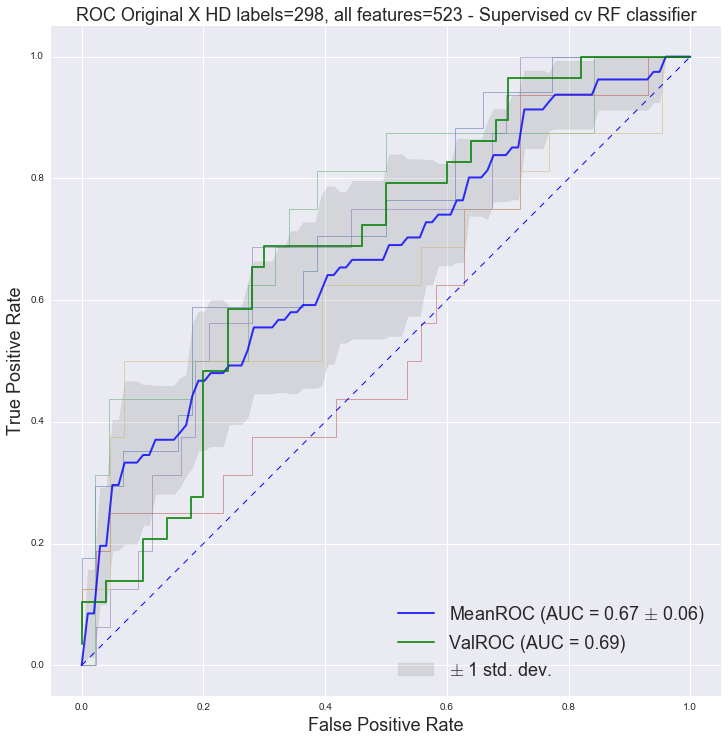

In [2]:
# unbiased validation with held-out set
sep = int(combX_allNME.shape[0]*0.10)
X_val = combX_allNME[:sep]
y_val = roi_labels[:sep]

X_train = combX_allNME[sep:]
y_train = roi_labels[sep:]

# Classification and ROC analysis
datalabels = np.asarray(y_train)
dataspace = X_train
X = dataspace[datalabels!='K',:]
y = np.asarray(datalabels[datalabels!='K']=='M').astype(int)

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
RFmodel = RandomForestClassifier(n_jobs=2, n_estimators=500, max_depth=3, random_state=0, verbose=0)

# Evaluate a score by cross-validation
figROCs = plt.figure(figsize=(12,12))                  
tprs = []; aucs = []
mean_fpr = np.linspace(0, 1, 100)
cvi = 0
for train, test in cv.split(X, y):
    probas = RFmodel.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas[:, 1])
    # to create an ROC with 100 pts
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    # plot
    axaroc = figROCs.add_subplot(1,1,1)
    axaroc.plot(fpr, tpr, lw=1, alpha=0.5) # with label add: label='cv %d, AUC %0.2f' % (cvi, roc_auc)
    cvi += 1

axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b',alpha=1)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
axaroc.plot(mean_fpr, mean_tpr, color='b',
         label=r'MeanROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)     
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.') 

################
# plot AUC on validation set
################
y_val_bin = (np.asarray(y_val)=='M').astype(int)
probas_val = RFmodel.fit(X, y).predict_proba(X_val)

# Compute ROC curve and area the curve
fpr_val, tpr_val, thresholds_val = roc_curve(y_val_bin, probas_val[:, 1])
auc_val = auc(fpr_val, tpr_val)
axaroc.plot(fpr_val, tpr_val, color='g',
            label=r'ValROC (AUC = %0.2f)' % (auc_val),
             lw=2, alpha=.8)     


axaroc.set_xlim([-0.05, 1.05])
axaroc.set_ylim([-0.05, 1.05])
axaroc.set_xlabel('False Positive Rate',fontsize=18)
axaroc.set_ylabel('True Positive Rate',fontsize=18)
axaroc.set_title('ROC Original X HD labels={}, all features={} - Supervised cv RF classifier'.format(X.shape[0],X.shape[1]), fontsize=18)
axaroc.legend(loc="lower right",fontsize=18)

# Explore variable importances

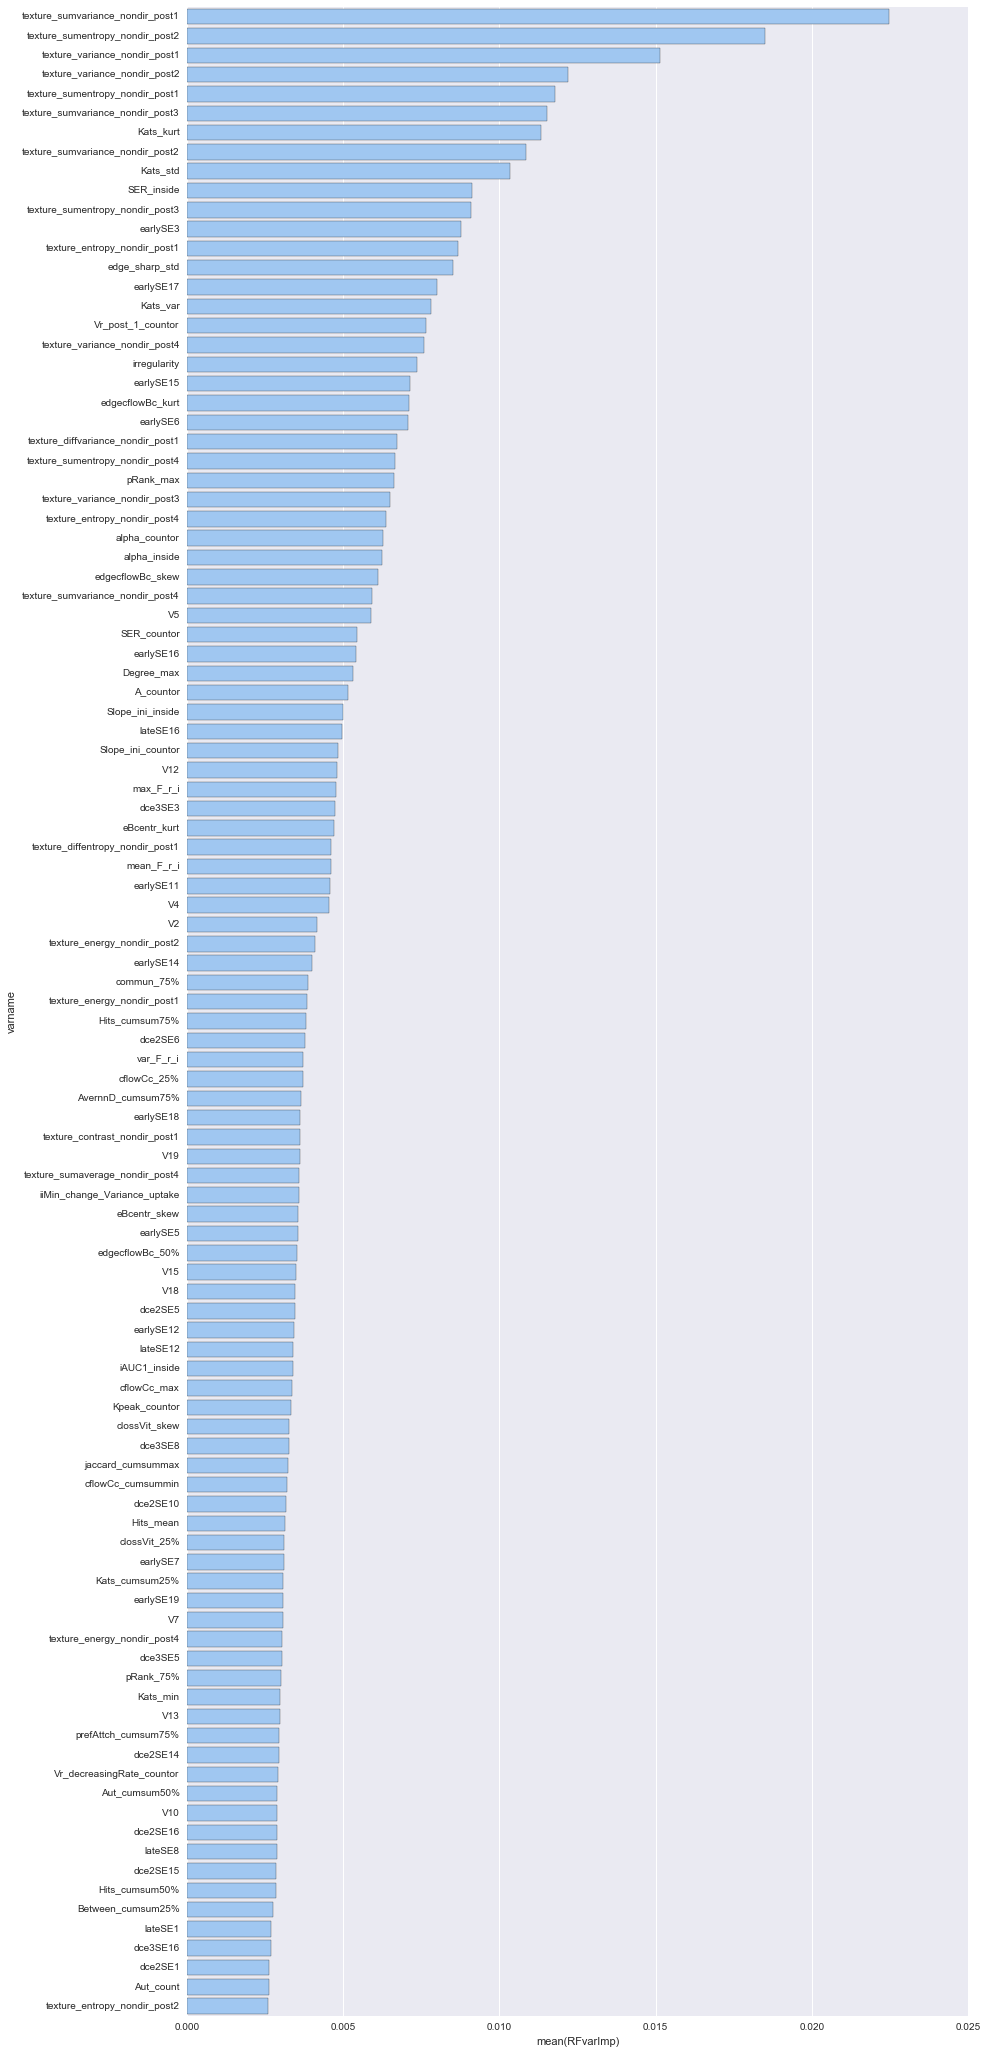

In [3]:
ind_featImp = np.argsort(RFmodel.feature_importances_)[::-1]
X_allNME_featurenames[ind_featImp]

# create pandas dF with variable importabces
RFfeatImportances = pd.DataFrame({'varname':X_allNME_featurenames[ind_featImp], 'RFvarImp':np.sort(RFmodel.feature_importances_)[::-1]})

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(14, 36))
# Plot the total crashes
sns.set_color_codes("pastel")
# of all 523 variables seclec those wiht positive varImportances
varDiscrim = RFfeatImportances[RFfeatImportances['RFvarImp']>0.0]

# top 20% = 523*0.20
varDiscrim = RFfeatImportances.iloc[0:int(523*0.20)]
sns.barplot(x="RFvarImp", y="varname", data=varDiscrim, label="varname", color="b")


#############################################################################
## 2) Unsupervised learning in optimal LD space:

### NOTES:  Z-space takes normalized variables  (zero mean and unit variance)

In [4]:
### Read input variables
# shape inputs     
nxGdiscfeatures = discrall_dict_allNMEs   
print('Loading {} leasions with nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

print('Normalizing dynamic {} leasions with features of size = {}'.format(allNMEs_dynamic.shape[0], allNMEs_dynamic.shape[1]))
normdynamic = (allNMEs_dynamic - allNMEs_dynamic.mean(axis=0)) / allNMEs_dynamic.std(axis=0)
normdynamic.mean(axis=0)
print(np.min(normdynamic, 0))
print(np.max(normdynamic, 0))

print('Normalizing morphology {} leasions with features of size = {}'.format(allNMEs_morphology.shape[0], allNMEs_morphology.shape[1]))
normorpho = (allNMEs_morphology - allNMEs_morphology.mean(axis=0)) / allNMEs_morphology.std(axis=0)
normorpho.mean(axis=0)
print(np.min(normorpho, 0))
print(np.max(normorpho, 0))

print('Normalizing texture {} leasions with features of size = {}'.format(allNMEs_texture.shape[0], allNMEs_texture.shape[1]))
normtext = (allNMEs_texture - allNMEs_texture.mean(axis=0)) / allNMEs_texture.std(axis=0)
normtext.mean(axis=0)
print(np.min(normtext, 0))
print(np.max(normtext, 0))

print('Normalizing stage1 {} leasions with features of size = {}'.format(allNMEs_stage1.shape[0], allNMEs_stage1.shape[1]))
normstage1 = (allNMEs_stage1 - allNMEs_stage1.mean(axis=0)) / allNMEs_stage1.std(axis=0)
normstage1.mean(axis=0)
print(np.min(normstage1, 0))
print(np.max(normstage1, 0))    

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, normdynamic.as_matrix(), normorpho.as_matrix(), normtext.as_matrix(), normstage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} all NME of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0]) )


Loading 792 leasions with nxGdiscfeatures of size = 326
Normalizing dynamic 792 leasions with features of size = 34
A_countor                    -0.729144
A_inside                     -0.607260
Kpeak_countor               -25.549665
Kpeak_inside                -19.365208
SER_countor                  -2.226007
SER_inside                   -1.679716
Slope_ini_countor            -0.421757
Slope_ini_inside             -0.315942
Tpeak_countor                -0.189829
Tpeak_inside                 -0.303463
UptakeRate_countor           -0.223719
UptakeRate_inside            -0.223663
Vr_decreasingRate_countor    -0.128268
Vr_decreasingRate_inside     -0.103961
Vr_increasingRate_countor    -0.135128
Vr_increasingRate_inside     -0.135128
Vr_post_1_countor            -0.275803
Vr_post_1_inside             -0.108175
alpha_countor                -0.290636
alpha_inside                 -0.296050
beta_countor                 -0.852320
beta_inside                  -0.789551
iAUC1_countor             

## 3) Unsupervised learning in optimal LD space: DEC + fully connected MLP classifier

## Experiment: decModel_wimgF_dualopt_descStats
### Training NOTES:

In [5]:
X_train = combX_allNME
y_train = roi_labels
    
print('SAE trained on ALL pooled variables, HD n= 523')
print('zero normed LD Z-space znum = reduced [x2,x5,x10,x15,x25]: \nSAE_zsize{znum}_wimgfeatures_descStats_zeromean.arg \n')

print('DEC optimization = Solver(sgd, learning_rate=0.1,lr_scheduler=mx.misc.FactorScheduler(100,0.1)) \n')
DEC_batch_size = 125     
update_interval = 20
epochs_update = float(DEC_batch_size*update_interval)/X_train.shape[0]
print('DEC batch_size = {}, update_interval = {} \nTraining DEC, updating parameters every ~ {} Epochs \n '.format(DEC_batch_size,update_interval,epochs_update))

print('DEC overall_metric = -np.log(mean_auc) -np.log(1-DECmetric) \n ')

MLP_batch_size = 50
print('MLP batch_size = {}, Training DEC + MLP fully connected classifier \n '.format(MLP_batch_size))


SAE trained on ALL pooled variables, HD n= 523
zero normed LD Z-space znum = reduced [x2,x5,x10,x15,x25]: 
SAE_zsize{znum}_wimgfeatures_descStats_zeromean.arg 

DEC optimization = Solver(sgd, learning_rate=0.1,lr_scheduler=mx.misc.FactorScheduler(100,0.1)) 

DEC batch_size = 125, update_interval = 20 
Training DEC, updating parameters every ~ 3.15656565657 Epochs 
 
DEC overall_metric = -np.log(mean_auc) -np.log(1-DECmetric) 
 
MLP batch_size = 50, Training DEC + MLP fully connected classifier 
 


Loading autoencoder of znum = 261, mu = 3 , post training DEC results
DEC train init AUC = 0.687024658348
DEC train max meanAuc_cv = 0.728015448604
DEC validation AUC at max meanAuc_cv = 0.707586206897
... num_centers=3 DEC normalizedMI = 0.0380271304196

Loading autoencoder of znum = 261, mu = 4 , post training DEC results
DEC train init AUC = 0.709454842543
DEC train max meanAuc_cv = 0.728490790255
DEC validation AUC at max meanAuc_cv = 0.728275862069
... num_centers=4 DEC normalizedMI = 0.115462975623

Loading autoencoder of znum = 261, mu = 5 , post training DEC results
DEC train init AUC = 0.715173796791
DEC train max meanAuc_cv = 0.720833333333
DEC validation AUC at max meanAuc_cv = 0.759310344828
... num_centers=5 DEC normalizedMI = 0.0805058162227

Loading autoencoder of znum = 261, mu = 6 , post training DEC results
DEC train init AUC = 0.679226084373
DEC train max meanAuc_cv = 0.720127748069
DEC validation AUC at max meanAuc_cv = 0.751724137931
... num_centers=6 DEC normalize

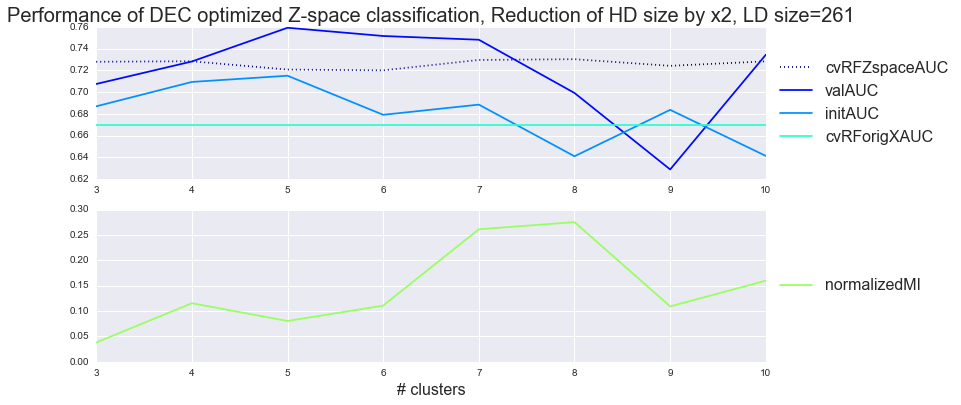

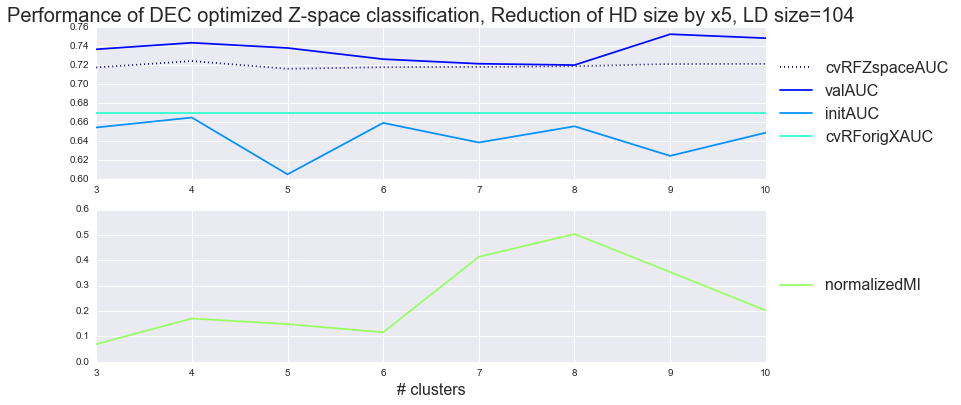

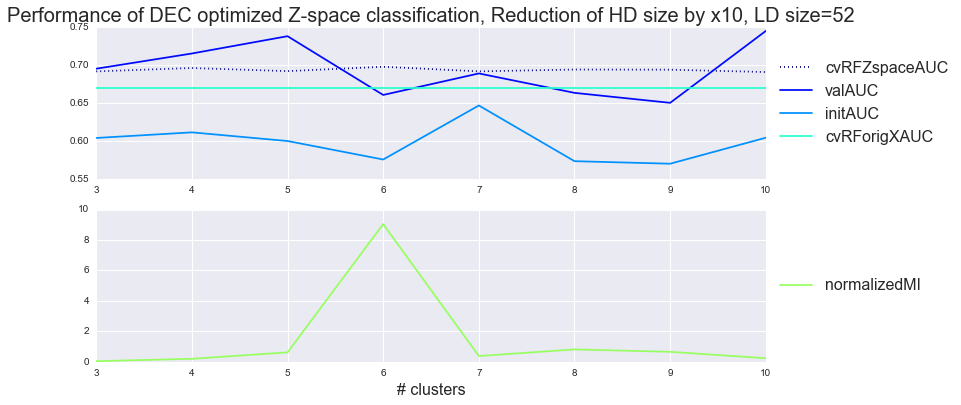

In [6]:
# set config variables
from decModel_wimgF_dualopt_descStats import *
labeltype = 'wimgF_dualopt_descStats' 
save_to = r'Z:\Cristina\Section3\NME_DEC\SAEmodels\decModel_wimgF_dualopt_descStats'

# to load a prevously DEC model  
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [2,5,10]] # other: 10,15,25
varying_mu = [int(np.round(var_mu)) for var_mu in np.linspace(3,10,8)]

######################
# DEC: define num_centers according to clustering variable
######################   
# to load a prevously DEC model  
for znum in latent_size:
    cvRForigXAUC = []
    initAUC = []
    valAUC = []
    cvRFZspaceAUC = []           
    normalizedMI = []
    for num_centers in varying_mu: 
        # batch normalization
        X_train = combX_allNME
        y_dec_train = y_dec
        y_train = roi_labels
        batch_size = X_train.shape[0]

        print('Loading autoencoder of znum = {}, mu = {} , post training DEC results'.format(znum,num_centers))
        dec_model = DECModel(mx.cpu(), X_train, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 

        with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            dec_model = pickle.load(fu)

        with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            outdict = pickle.load(fu)

        print('DEC train init AUC = {}'.format(outdict['meanAuc_cv'][0]))
        max_meanAuc_cv = max(outdict['meanAuc_cv'])
        indmax_meanAuc_cv = outdict['meanAuc_cv'].index(max_meanAuc_cv)
        print('DEC train max meanAuc_cv = {}'.format(max_meanAuc_cv))
        print('DEC validation AUC at max meanAuc_cv = {}'.format(outdict['auc_val'][indmax_meanAuc_cv]))
        
        
        # to plot metrics for all varying_mu
        cvRForigXAUC.append(0.67)
        initAUC.append(outdict['meanAuc_cv'][0])
        cvRFZspaceAUC.append(outdict['meanAuc_cv'][indmax_meanAuc_cv])
        valAUC.append(outdict['auc_val'][indmax_meanAuc_cv])
        # or to calculate NMI
        # save output results
        dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
        'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
        'encoder_3_bias', 'encoder_2_bias']
        dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
        dec_args['dec_mubestacci'] = dec_model['dec_mubestacci']
        
        # Calculate normalized MI: find the relative frequency of points in Wk and Cj
        #####################
        N = X_train.shape[0]
        num_classes = len(np.unique(roi_labels)) # present but not needed during AE training
        roi_classes = np.unique(roi_labels)
        y_train_roi_labels = np.asarray(y_train)
        
        # extact embedding space
        all_iter = mx.io.NDArrayIter({'data': X_train}, batch_size=X_train.shape[0], shuffle=False,
                                                  last_batch_handle='pad')   
        ## embedded point zi 
        aDEC = DECModel(mx.cpu(), X_train, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 
        mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
        
        # gather best-Zspace or dec_model['zbestacci']
        zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X_train.shape[0], aDEC.xpu).values()[0]      
        # compute model-based best-pbestacci or dec_model['pbestacci']
        # pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
        # aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
        pbestacci = dec_model['pbestacci']
        
        # find max soft assignments dec_args
        W = pbestacci.argmax(axis=1)
        clusters = range(dec_model['num_centers'])
        num_clusters = len(np.unique(W))
        
        MLE_kj = np.zeros((num_clusters,num_classes))
        absWk = np.zeros((num_clusters))
        absCj = np.zeros((num_classes))
        for k in range(num_clusters):
            # find poinst in cluster k
            absWk[k] = np.sum(W==k)
            for j in range(num_classes):
                # find points of class j
                absCj[j] = np.sum(y_train_roi_labels==roi_classes[j])
                # find intersection 
                ptsk = W==k
                MLE_kj[k,j] = np.sum(ptsk[y_train_roi_labels==roi_classes[j]])
        # if not assignment incluster
        absWk[absWk==0]=0.00001
        # compute NMI
        numIwc = np.zeros((num_clusters,num_classes))
        for k in range(num_clusters):
            for j in range(num_classes):
                if(MLE_kj[k,j]!=0):
                    numIwc[k,j] = MLE_kj[k,j]/N * np.log( N*MLE_kj[k,j]/(absWk[k]*absCj[j]) )
                
        Iwk = np.sum(np.sum(numIwc, axis=1), axis=0)       
        Hc = -np.sum(absCj/N*np.log(absCj/N))
        Hw = np.sum(absWk/N*np.log(absWk/N))
        NMI = Iwk/(np.abs(Hc+Hw))
        print("... num_centers={} DEC normalizedMI = {}".format(num_centers,NMI))
        normalizedMI.append(NMI)
        print("========================\n")
    
    # plot latent space Accuracies vs. original
    colors = plt.cm.jet(np.linspace(0, 1, 16))
    fig2 = plt.figure(figsize=(12,6))
    #ax2 = plt.axes()
    sns.set_context("notebook")
    ax1 = fig2.add_subplot(2,1,1)
    ax1.plot(varying_mu, cvRFZspaceAUC, color=colors[0], ls=':', label='cvRFZspaceAUC')
    ax1.plot(varying_mu, valAUC, color=colors[2], label='valAUC')
    ax1.plot(varying_mu, initAUC, color=colors[4], label='initAUC')
    ax1.plot(varying_mu, cvRForigXAUC, color=colors[6], label='cvRForigXAUC')
    h1, l1 = ax1.get_legend_handles_labels()
    ax1.legend(h1, l1, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':16})
    
    ax2 = fig2.add_subplot(2,1,2)
    ax2.plot(varying_mu, normalizedMI, color=colors[8], label='normalizedMI')
    h2, l2 = ax2.get_legend_handles_labels()
    ax2.legend(h2, l2, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':16})
    ax2.set_xlabel('# clusters',fontsize=16)
    ax1.set_title('Performance of DEC optimized Z-space classification, Reduction of HD size by x{}, LD size={}'.format(input_size/znum, znum),fontsize=20)
        

# Plotting ROC AUC in optimized embedded space
## 4) Unsupervised learning in optimal LD space: Fitting aN MLP DUAL OPTIMIZATION


Loading autoencoder of znum = 261, mu = 3 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


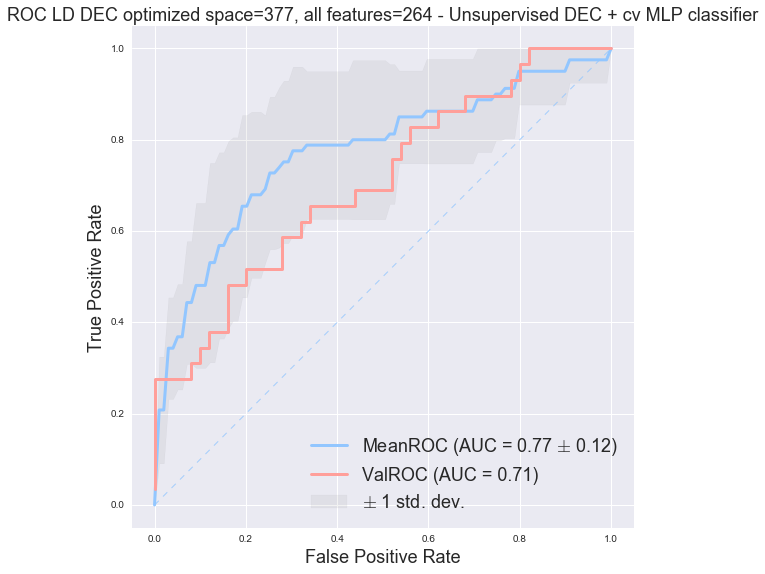

DEC train init AUC = 0.687024658348
DEC train max meanAuc_cv = 0.773578 $\pm$ 0.12
DEC validation AUC at max meanAuc_cv = 0.707586206897
... num_centers=3 DEC normalizedMI = 0.0380271304196

Loading autoencoder of znum = 261, mu = 4 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


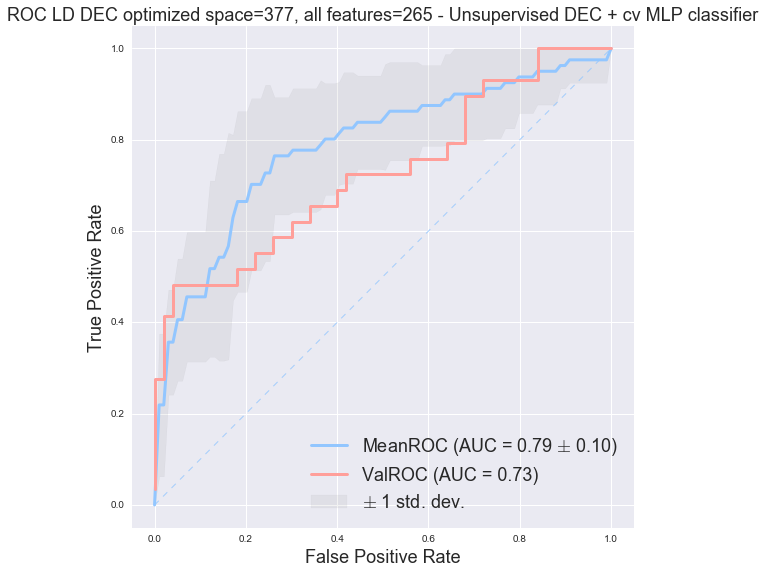

DEC train init AUC = 0.709454842543
DEC train max meanAuc_cv = 0.787010 $\pm$ 0.10
DEC validation AUC at max meanAuc_cv = 0.726896551724
... num_centers=4 DEC normalizedMI = 0.115462975623

Loading autoencoder of znum = 261, mu = 5 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


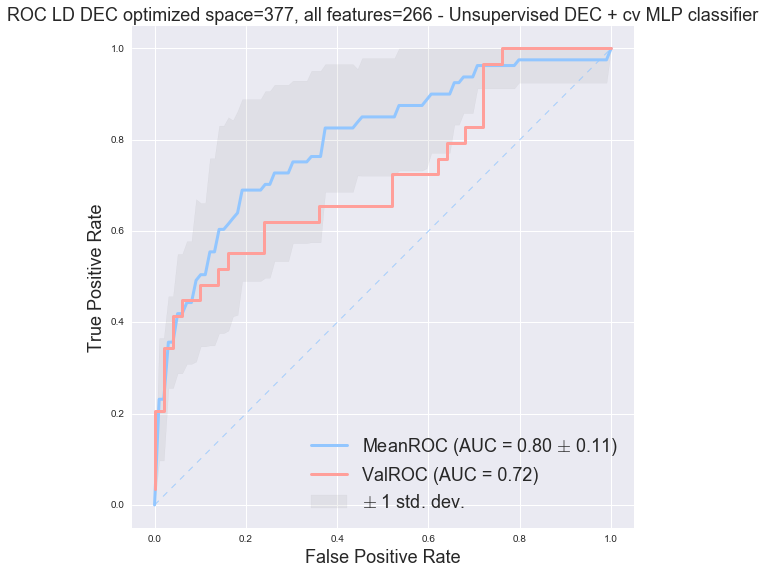

DEC train init AUC = 0.715173796791
DEC train max meanAuc_cv = 0.799110 $\pm$ 0.11
DEC validation AUC at max meanAuc_cv = 0.721379310345
... num_centers=5 DEC normalizedMI = 0.0805058162227

Loading autoencoder of znum = 261, mu = 6 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


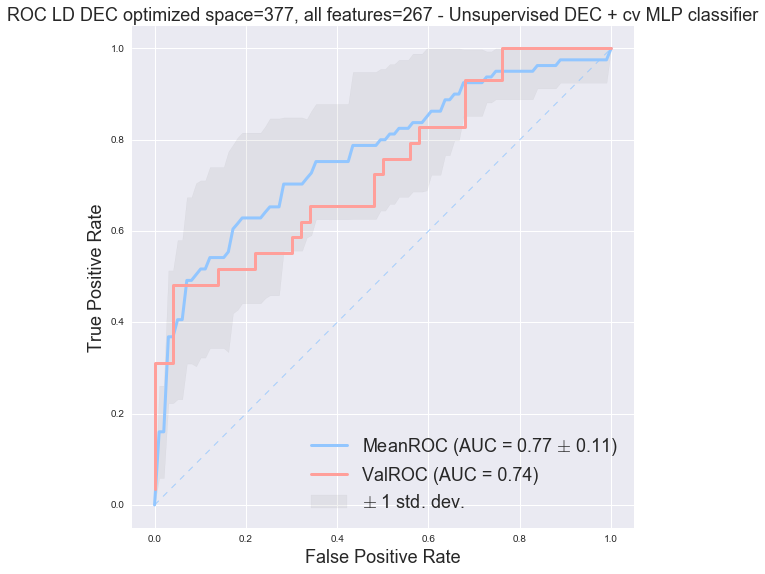

DEC train init AUC = 0.679226084373
DEC train max meanAuc_cv = 0.769368 $\pm$ 0.11
DEC validation AUC at max meanAuc_cv = 0.735172413793
... num_centers=6 DEC normalizedMI = 0.110750329021

Loading autoencoder of znum = 261, mu = 7 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


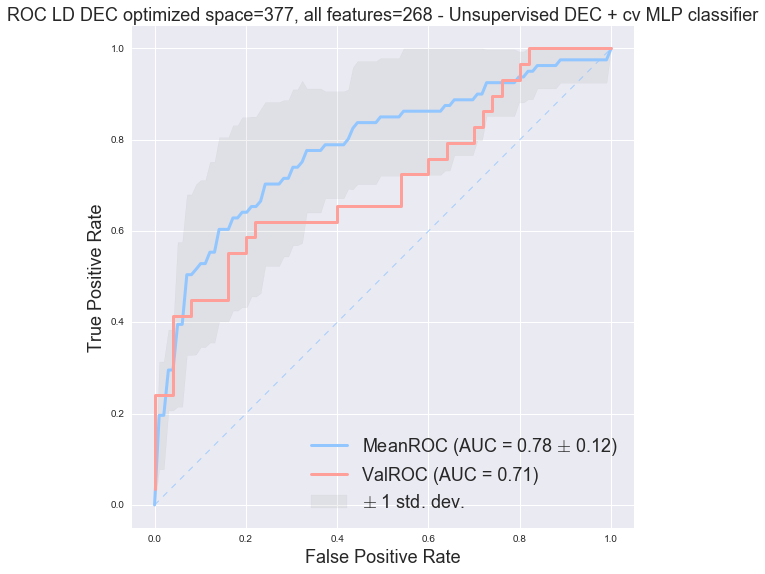

DEC train init AUC = 0.688591800357
DEC train max meanAuc_cv = 0.782851 $\pm$ 0.12
DEC validation AUC at max meanAuc_cv = 0.708965517241
... num_centers=7 DEC normalizedMI = 0.261274043175

Loading autoencoder of znum = 261, mu = 8 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


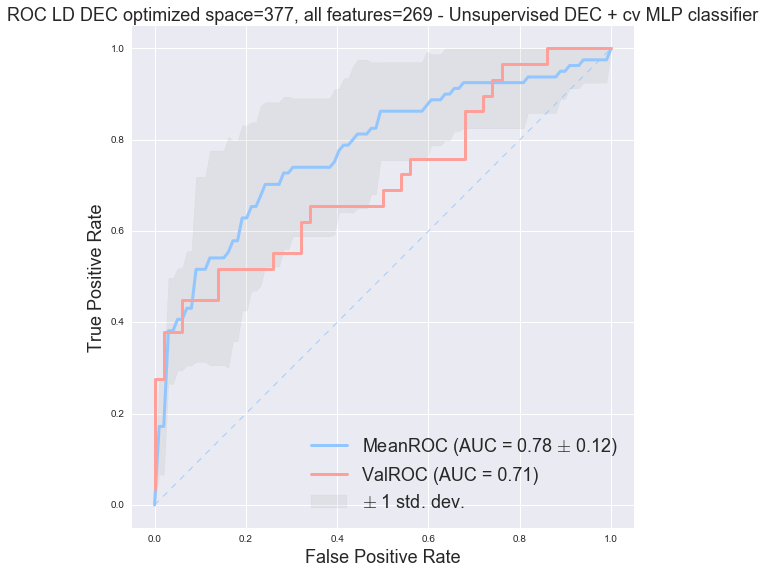

DEC train init AUC = 0.641087344029
DEC train max meanAuc_cv = 0.776739 $\pm$ 0.12
DEC validation AUC at max meanAuc_cv = 0.709655172414
... num_centers=8 DEC normalizedMI = 0.275393518785

Loading autoencoder of znum = 261, mu = 9 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


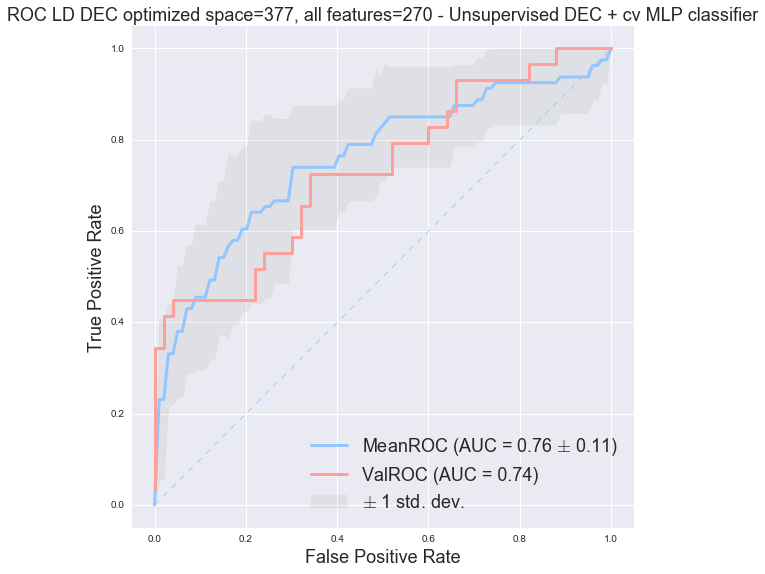

DEC train init AUC = 0.683793820559
DEC train max meanAuc_cv = 0.757708 $\pm$ 0.11
DEC validation AUC at max meanAuc_cv = 0.735172413793
... num_centers=9 DEC normalizedMI = 0.109185633982

Loading autoencoder of znum = 261, mu = 10 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


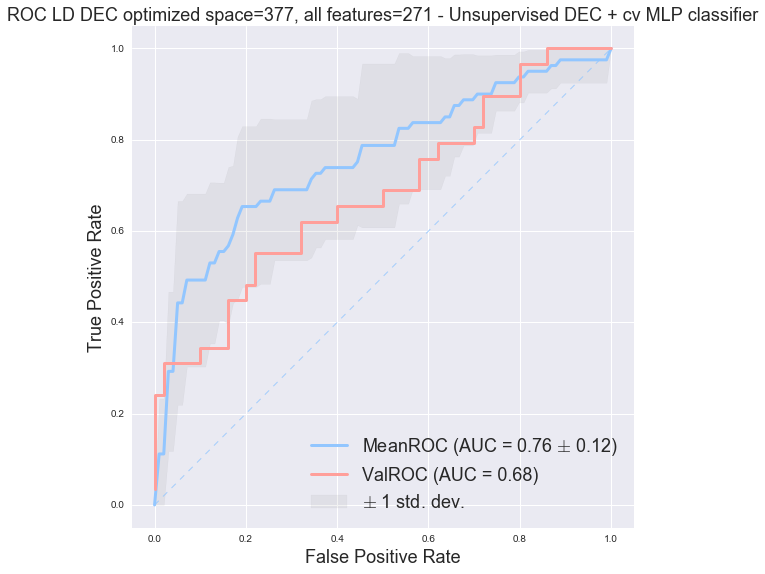

DEC train init AUC = 0.641421568627
DEC train max meanAuc_cv = 0.758632 $\pm$ 0.12
DEC validation AUC at max meanAuc_cv = 0.683448275862
... num_centers=10 DEC normalizedMI = 0.159918502424

Loading autoencoder of znum = 104, mu = 3 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


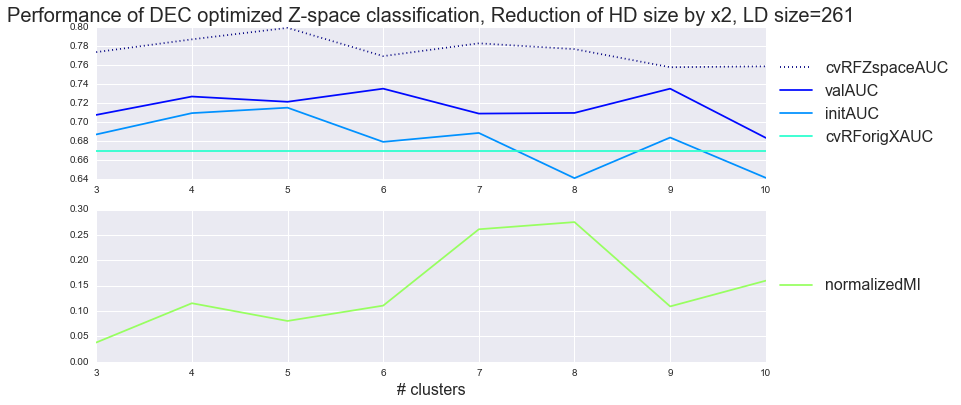

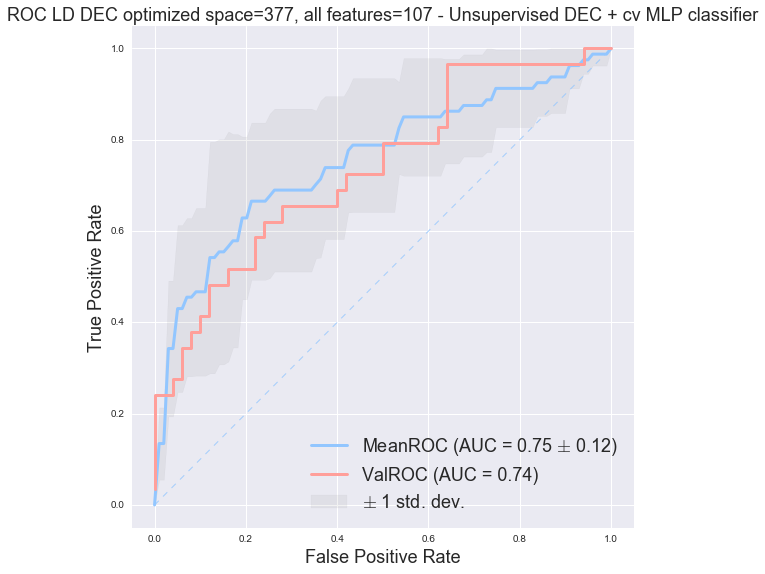

DEC train init AUC = 0.654367201426
DEC train max meanAuc_cv = 0.755251 $\pm$ 0.12
DEC validation AUC at max meanAuc_cv = 0.736551724138
... num_centers=3 DEC normalizedMI = 0.0694198866279

Loading autoencoder of znum = 104, mu = 4 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


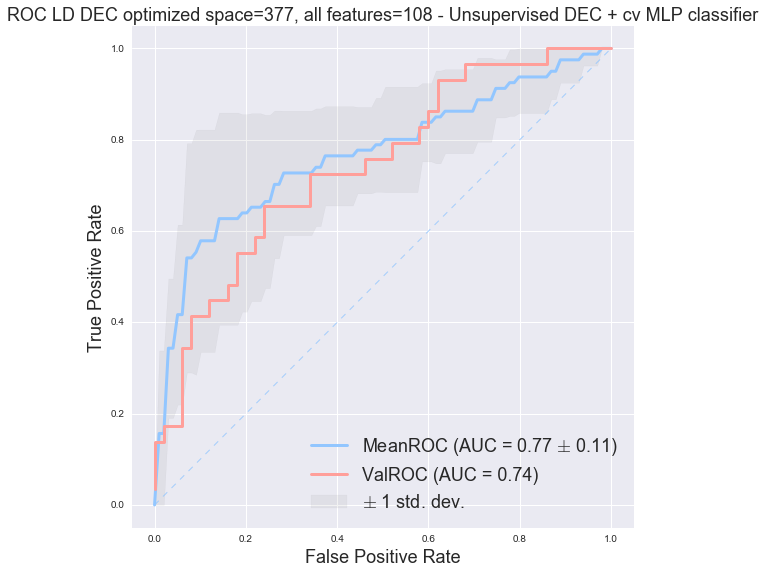

DEC train init AUC = 0.664802436126
DEC train max meanAuc_cv = 0.769382 $\pm$ 0.11
DEC validation AUC at max meanAuc_cv = 0.743448275862
... num_centers=4 DEC normalizedMI = 0.170702393432

Loading autoencoder of znum = 104, mu = 5 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


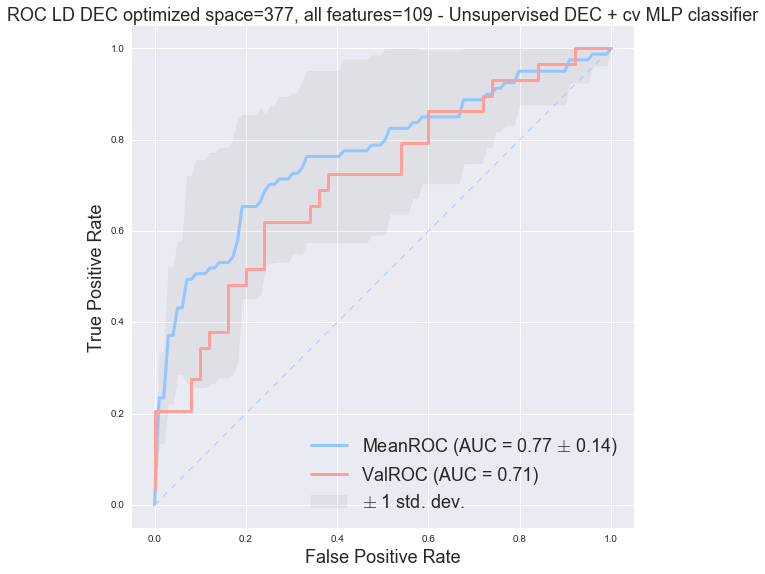

DEC train init AUC = 0.60509506833
DEC train max meanAuc_cv = 0.769002 $\pm$ 0.14
DEC validation AUC at max meanAuc_cv = 0.708275862069
... num_centers=5 DEC normalizedMI = 0.148668705062

Loading autoencoder of znum = 104, mu = 6 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


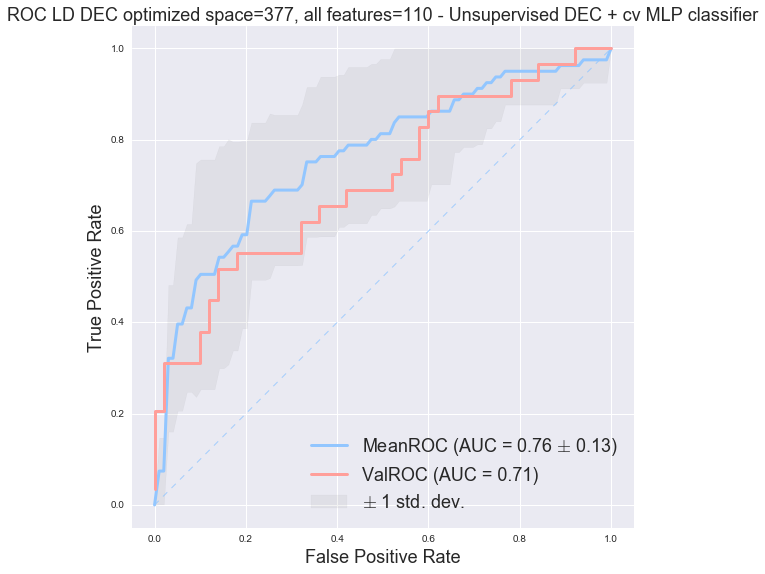

DEC train init AUC = 0.659180035651
DEC train max meanAuc_cv = 0.764226 $\pm$ 0.13
DEC validation AUC at max meanAuc_cv = 0.711724137931
... num_centers=6 DEC normalizedMI = 0.116292181522

Loading autoencoder of znum = 104, mu = 7 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


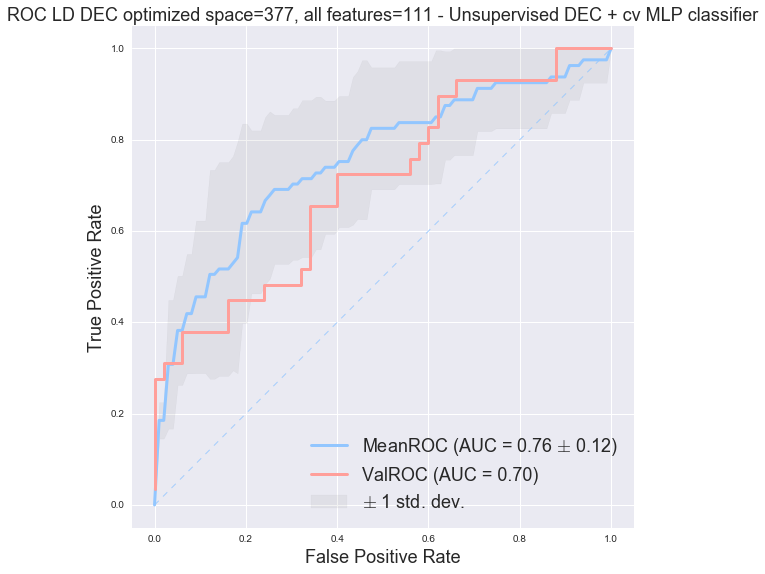

DEC train init AUC = 0.638569518717
DEC train max meanAuc_cv = 0.756389 $\pm$ 0.12
DEC validation AUC at max meanAuc_cv = 0.704137931034
... num_centers=7 DEC normalizedMI = 0.413886473675

Loading autoencoder of znum = 104, mu = 8 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


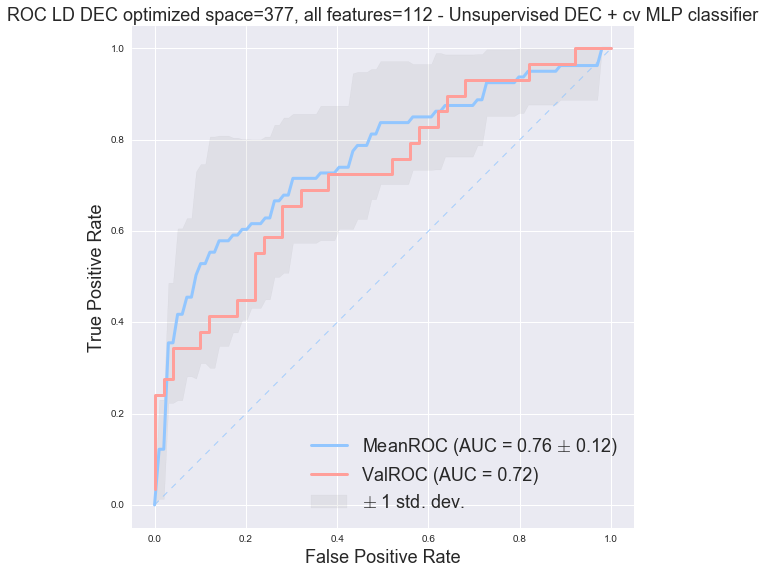

DEC train init AUC = 0.655600118835
DEC train max meanAuc_cv = 0.762328 $\pm$ 0.12
DEC validation AUC at max meanAuc_cv = 0.724137931034
... num_centers=8 DEC normalizedMI = 0.503735285093

Loading autoencoder of znum = 104, mu = 9 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


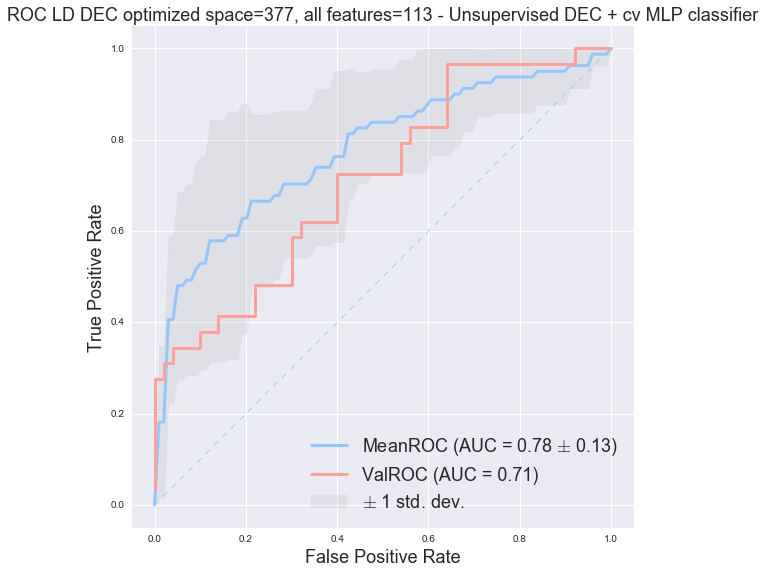

DEC train init AUC = 0.624517231135
DEC train max meanAuc_cv = 0.779557 $\pm$ 0.13
DEC validation AUC at max meanAuc_cv = 0.714482758621
... num_centers=9 DEC normalizedMI = 0.354081617994

Loading autoencoder of znum = 104, mu = 10 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


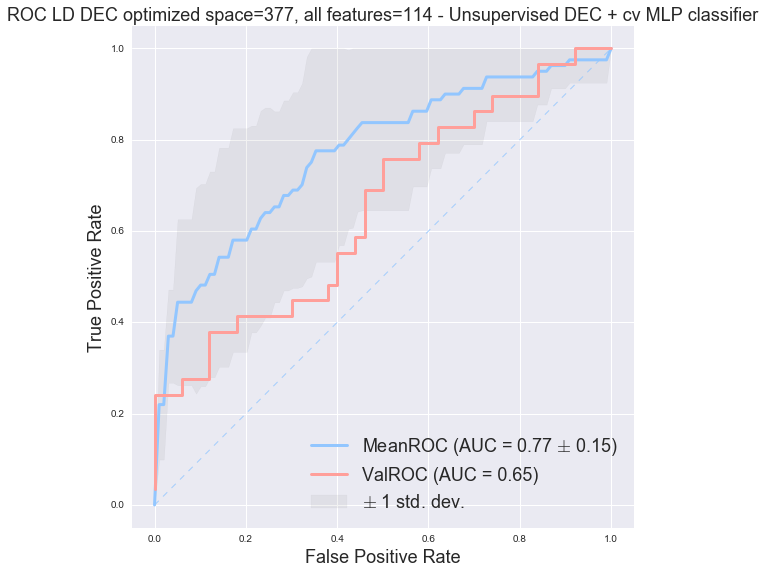

DEC train init AUC = 0.64890077243
DEC train max meanAuc_cv = 0.772757 $\pm$ 0.15
DEC validation AUC at max meanAuc_cv = 0.650344827586
... num_centers=10 DEC normalizedMI = 0.202310332647

Loading autoencoder of znum = 52, mu = 3 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


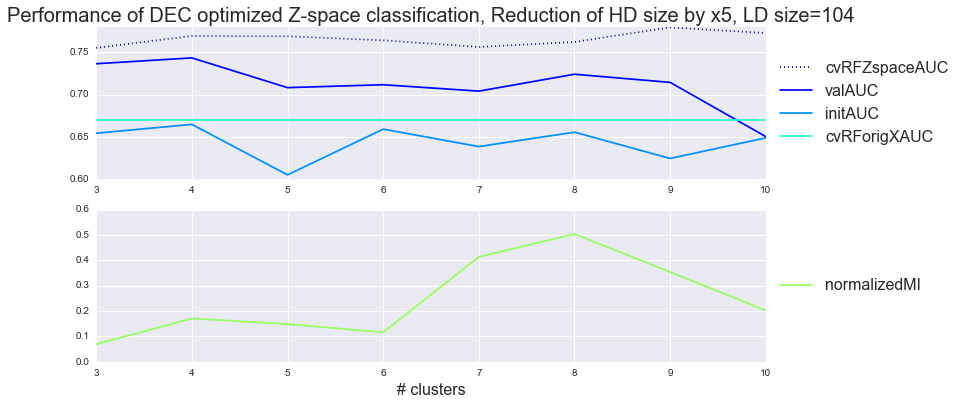

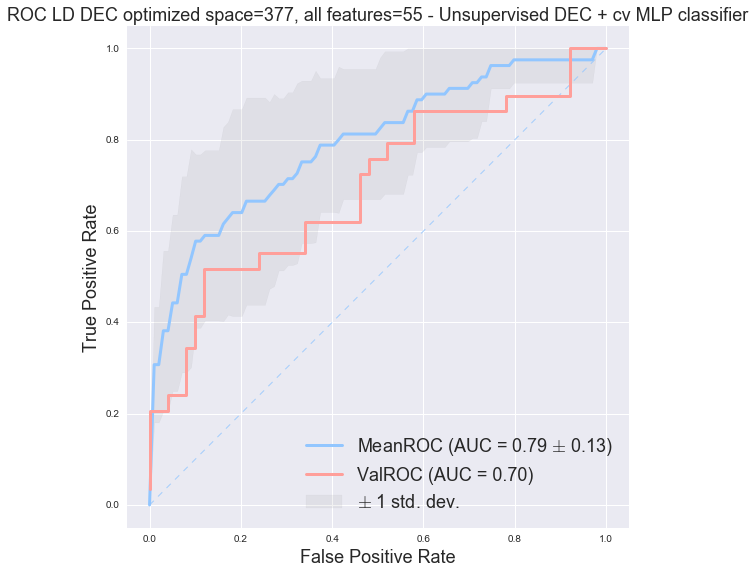

DEC train init AUC = 0.604159239453
DEC train max meanAuc_cv = 0.792837 $\pm$ 0.13
DEC validation AUC at max meanAuc_cv = 0.695172413793
... num_centers=3 DEC normalizedMI = 0.0418730926108

Loading autoencoder of znum = 52, mu = 4 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


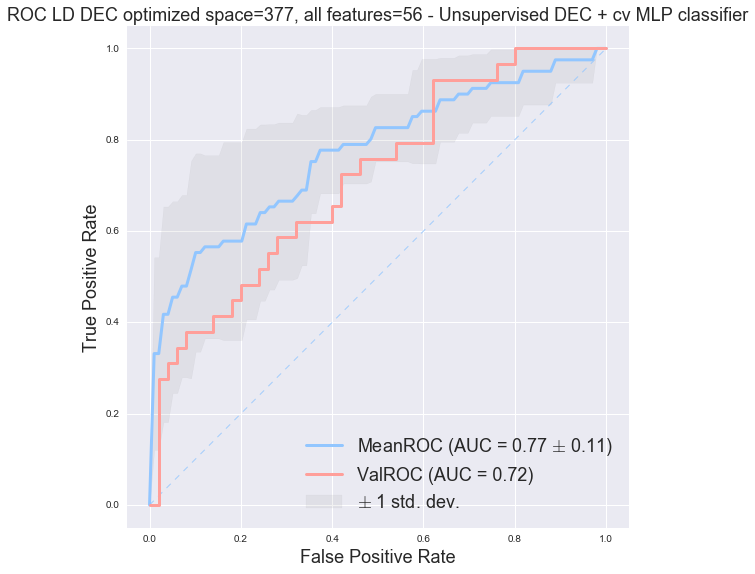

DEC train init AUC = 0.61153446227
DEC train max meanAuc_cv = 0.772386 $\pm$ 0.11
DEC validation AUC at max meanAuc_cv = 0.715862068966
... num_centers=4 DEC normalizedMI = 0.19715637433

Loading autoencoder of znum = 52, mu = 5 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


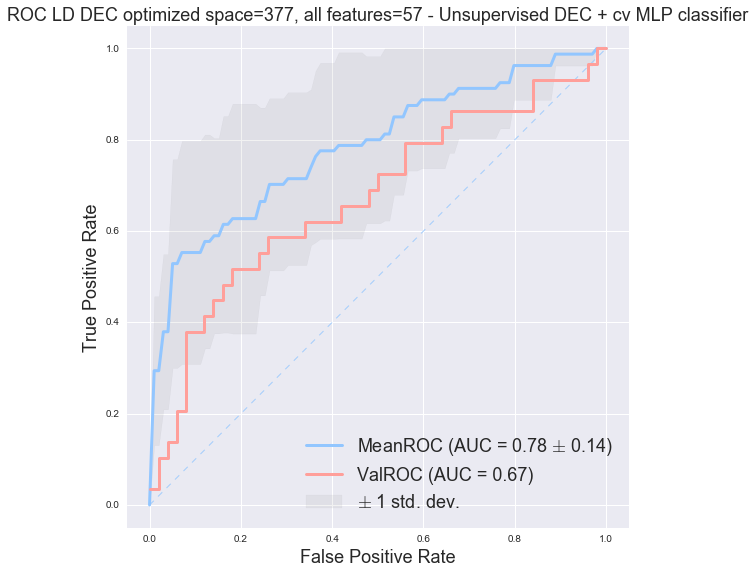

DEC train init AUC = 0.600163398693
DEC train max meanAuc_cv = 0.786161 $\pm$ 0.14
DEC validation AUC at max meanAuc_cv = 0.673103448276
... num_centers=5 DEC normalizedMI = 0.619483170252

Loading autoencoder of znum = 52, mu = 6 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


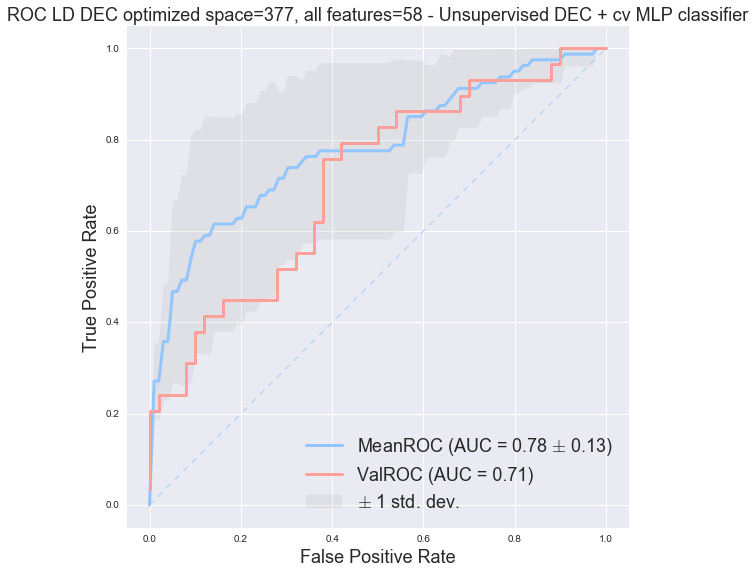

DEC train init AUC = 0.575846702317
DEC train max meanAuc_cv = 0.781234 $\pm$ 0.13
DEC validation AUC at max meanAuc_cv = 0.710344827586
... num_centers=6 DEC normalizedMI = 9.04781179972

Loading autoencoder of znum = 52, mu = 7 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


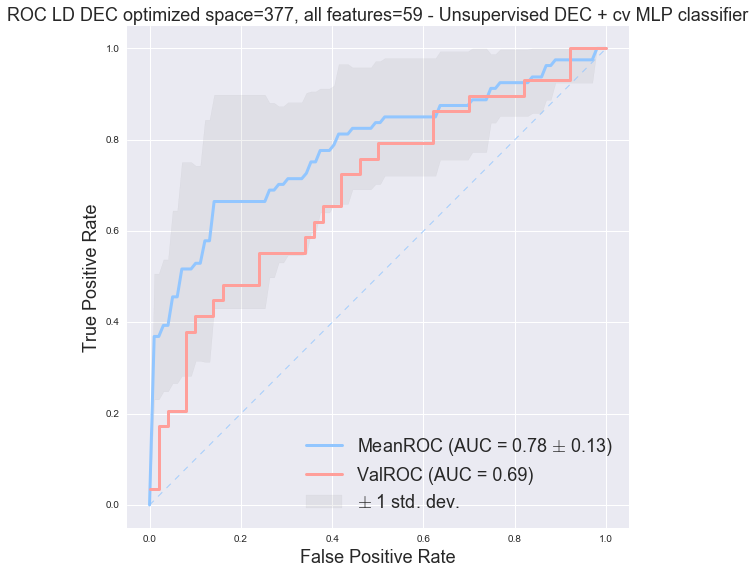

DEC train init AUC = 0.646843434343
DEC train max meanAuc_cv = 0.785252 $\pm$ 0.13
DEC validation AUC at max meanAuc_cv = 0.693793103448
... num_centers=7 DEC normalizedMI = 0.380735922992

Loading autoencoder of znum = 52, mu = 8 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


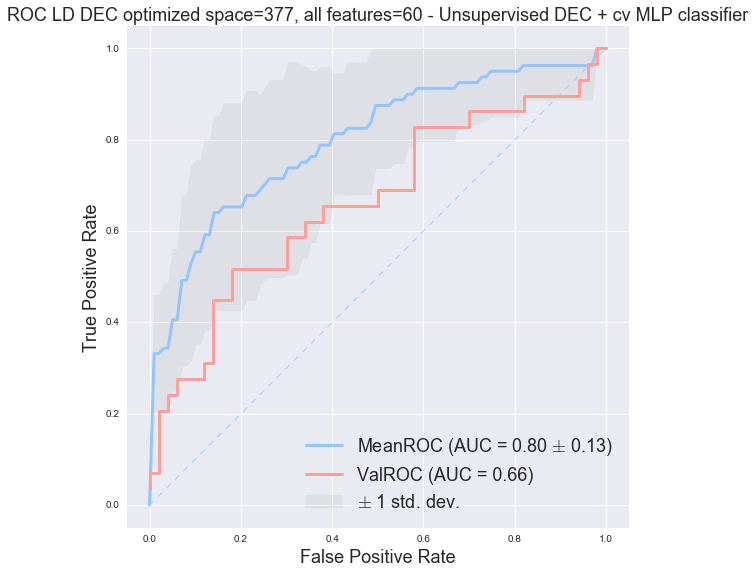

DEC train init AUC = 0.573663101604
DEC train max meanAuc_cv = 0.799503 $\pm$ 0.13
DEC validation AUC at max meanAuc_cv = 0.663448275862
... num_centers=8 DEC normalizedMI = 0.813552550256

Loading autoencoder of znum = 52, mu = 9 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


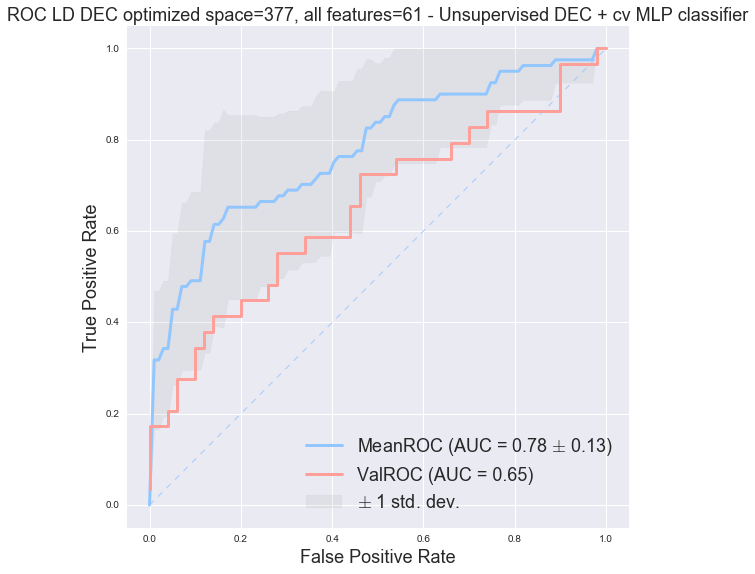

DEC train init AUC = 0.570328282828
DEC train max meanAuc_cv = 0.779401 $\pm$ 0.13
DEC validation AUC at max meanAuc_cv = 0.651724137931
... num_centers=9 DEC normalizedMI = 0.655007843519

Loading autoencoder of znum = 52, mu = 10 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


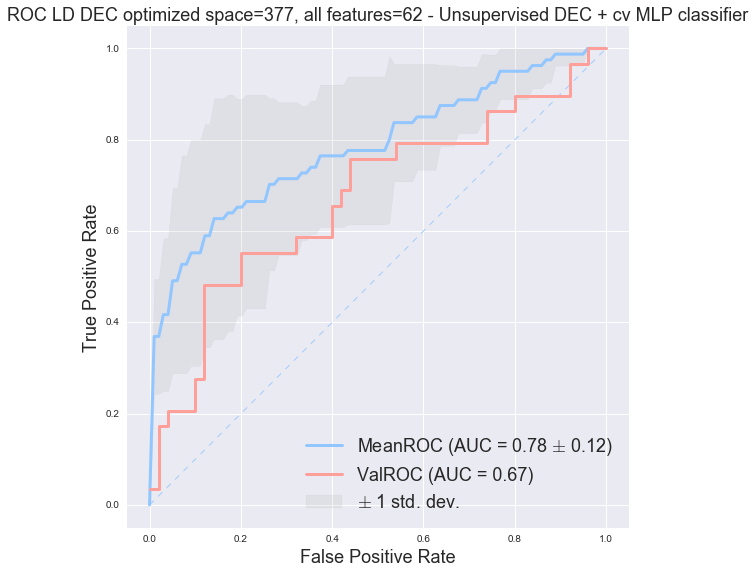

DEC train init AUC = 0.604471182412
DEC train max meanAuc_cv = 0.783894 $\pm$ 0.12
DEC validation AUC at max meanAuc_cv = 0.673103448276
... num_centers=10 DEC normalizedMI = 0.235793212013



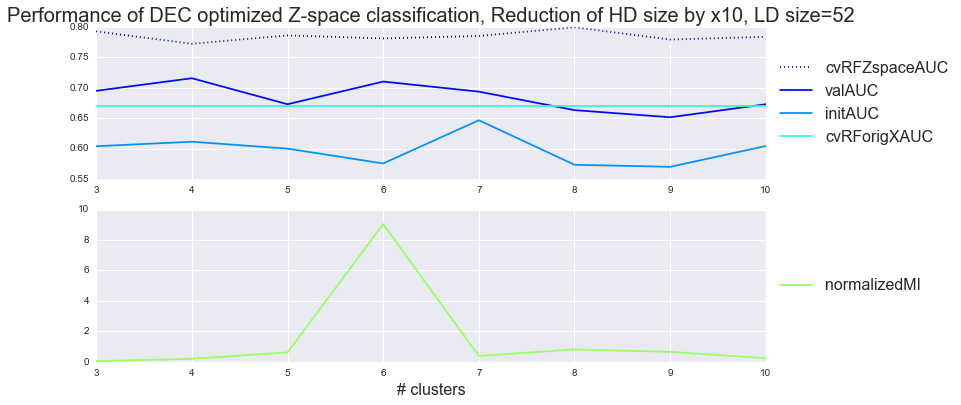

In [10]:
# set config variables
from decModel_wimgF_dualopt_descStats import *
labeltype = 'wimgF_dualopt_descStats' 
save_to = r'Z:\Cristina\Section3\NME_DEC\SAEmodels\decModel_wimgF_dualopt_descStats'

# to load a prevously DEC model  
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [2,5,10]]
varying_mu = [int(np.round(var_mu)) for var_mu in np.linspace(3,10,8)]

scoresM = np.zeros((len(latent_size),len(varying_mu),4))
scoresM_titles=[]
        
######################
# DEC: define num_centers according to clustering variable
######################   
# to load a prevously DEC model  
for ik,znum in enumerate(latent_size):
    cvRForigXAUC = []
    initAUC = []
    valAUC = []
    cvRFZspaceAUC = [] 
    normalizedMI = []
    for ic,num_centers in enumerate(varying_mu): 
        X = combX_allNME
        y = roi_labels

        print('Loading autoencoder of znum = {}, mu = {} , post training DEC results'.format(znum,num_centers))
        dec_model = DECModel(mx.cpu(), X, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 

        with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            dec_model = pickle.load(fu)
          
        with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            outdict = pickle.load(fu)

        #####################
        # extract Z-space from optimal DEC model
        #####################
        # saved output results
        dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
        'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
        'encoder_3_bias', 'encoder_2_bias']
        dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
        dec_args['dec_mubestacci'] = dec_model['dec_mu']
        
        N = X.shape[0]
        all_iter = mx.io.NDArrayIter({'data': X}, batch_size=X.shape[0], shuffle=False,
                                                  last_batch_handle='pad')   
        ## extract embedded point zi 
        mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
        aDEC = DECModel(mx.cpu(), X, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 
        
        # gather best-Zspace or dec_model['zbestacci']
        zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X.shape[0], aDEC.xpu).values()[0]      
        zbestacci = dec_model['zbestacci']
        
        # compute model-based best-pbestacci or dec_model['pbestacci']
        pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
        aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
        pbestacci = dec_model['pbestacci']
        
        # pool Z-space variables
        datalabels = np.asarray(y_train)
        dataZspace = np.concatenate((zbestacci, pbestacci), axis=1) 

        #####################
        # unbiased assessment: SPlit train/held-out test
        #####################
        # to compare performance need to discard unkown labels, only use known labels (only B or M)
        Z = dataZspace[datalabels!='K',:]
        y = datalabels[datalabels!='K']
      
        print '\n... MLP fully coneected layer trained on Z_train tested on Z_test' 
        sep = int(X.shape[0]*0.10)
        Z_test = Z[:sep]
        yZ_test = np.asanyarray(y[:sep]=='M').astype(int) 
        Z_train = Z[sep:]
        yZ_train = np.asanyarray(y[sep:]=='M').astype(int) 

        
        # We’ll load MLP using MXNet’s symbolic interface
        dataMLP = mx.sym.Variable('data')
        # MLP: two fully connected layers with 128 and 32 neurons each. 
        fc1  = mx.sym.FullyConnected(data=dataMLP, num_hidden = 128)
        act1 = mx.sym.Activation(data=fc1, act_type="relu")
        fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 32)
        act2 = mx.sym.Activation(data=fc2, act_type="relu")
        # data has 2 classes
        fc3  = mx.sym.FullyConnected(data=act2, num_hidden=2)
        # Softmax output layer
        mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
        # create a trainable module on CPU     
        batch_size = 50
        mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
        # pass train/test data to allocate model (bind state)
        MLP_train_iter = mx.io.NDArrayIter(Z_train, yZ_train, batch_size, shuffle=True)
        mlp_model.bind(MLP_train_iter.provide_data, MLP_train_iter.provide_label)
        mlp_model.init_params()        
        mlp_model_params = mlp_model.get_params()[0]
        
        # update parameters based on optimal found during cv Training
        from mxnet import ndarray
        params_dict = ndarray.load(os.path.join(save_to,'mlp_model_params_z{}_mu{}.arg'.format(znum,num_centers)))
        arg_params = {}
        aux_params = {}
        for k, value in params_dict.items():
            arg_type, name = k.split(':', 1)
            if arg_type == 'arg':
                arg_params[name] = value
            elif arg_type == 'aux':
                aux_params[name] = value
            else:
                raise ValueError("Invalid param file ")

        # order of params: [(128L, 266L),(128L,),(32L, 128L),(32L,),(2L, 32L),(2L,)]
        # organize weights and biases
        l1=[v.asnumpy().shape for k,v in mlp_model_params.iteritems()]
        k1=[k for k,v in mlp_model_params.iteritems()]
        l2=[v.asnumpy().shape for k,v in arg_params.iteritems()]
        k2=[k for k,v in arg_params.iteritems()]

        for ikparam,sizeparam in enumerate(l1):
            for jkparam,savedparam in enumerate(l2):
                if(sizeparam == savedparam):
                    #print('updating layer parameters: {}'.format(savedparam))
                    mlp_model_params[k1[ikparam]] = arg_params[k2[jkparam]]
        # upddate model parameters
        mlp_model.set_params(mlp_model_params, aux_params)
        
        #####################
        # ROC: Z-space MLP fully coneected layer for classification
        #####################
        figROCs = plt.figure(figsize=(9,9))    
        axaroc = figROCs.add_subplot(1,1,1)
        # Run classifier with cross-validation and plot ROC curves
        cv = StratifiedKFold(n_splits=5)
        # Evaluate a score by cross-validation
        tprs = []; aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        cvi = 0
        for train, test in cv.split(Z_train, yZ_train):
            # Pass cv data
            MLP_val_iter = mx.io.NDArrayIter(Z_train[test], yZ_train[test], batch_size)    
            # prob[i][j] is the probability that the i-th validation contains the j-th output class.
            prob_val = mlp_model.predict(MLP_val_iter)
            # Compute ROC curve and area the curve
            fpr, tpr, thresholds = roc_curve(yZ_train[test], prob_val.asnumpy()[:,1])
            # to create an ROC with 100 pts
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            # plot
            #axaroc.plot(fpr, tpr, lw=1, alpha=0.6) # with label add: label='cv %d, AUC %0.2f' % (cvi, roc_auc)
            cvi += 1
            
        axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='b', alpha=.8)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        axaroc.plot(mean_fpr, mean_tpr, color='b',label=r'MeanROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=3, alpha=1)     
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.1,label=r'$\pm$ 1 std. dev.') 
        
        ################
        # plot AUC on validation set
        ################
        MLP_heldout_iter = mx.io.NDArrayIter(Z_test, None, batch_size)   
        probas_heldout = mlp_model.predict(MLP_heldout_iter)
           
        # Compute ROC curve and area the curve
        fpr_val, tpr_val, thresholds_val = roc_curve(yZ_test, probas_heldout.asnumpy()[:, 1])
        auc_val = auc(fpr_val, tpr_val)
        axaroc.plot(fpr_val, tpr_val, color='r',label=r'ValROC (AUC = %0.2f)' % (auc_val),lw=3, alpha=1)     

        axaroc.set_xlim([-0.05, 1.05])
        axaroc.set_ylim([-0.05, 1.05])
        axaroc.set_xlabel('False Positive Rate',fontsize=18)
        axaroc.set_ylabel('True Positive Rate',fontsize=18)
        axaroc.set_title('ROC LD DEC optimized space={}, all features={} - Unsupervised DEC + cv MLP classifier'.format(Z.shape[0],Z.shape[1]),fontsize=18)
        axaroc.legend(loc="lower right",fontsize=18)
        plt.show()
        
        print('DEC train init AUC = {}'.format(dec_model['meanAuc_cv'][0]))
        print r'DEC train max meanAuc_cv = %0.6f $\pm$ %0.2f' % (np.mean(aucs), std_auc)
        print('DEC validation AUC at max meanAuc_cv = {}'.format(auc_val))
        cvRForigXAUC.append(0.67)
        initAUC.append(dec_model['meanAuc_cv'][0])
        cvRFZspaceAUC.append(np.mean(aucs))
        valAUC.append(auc_val)
        
        ################
        # Calculate NMI: find max soft assignments dec_args
        ################
        num_classes = len(np.unique(roi_labels))
        W = pbestacci.argmax(axis=1)
        clusters = range(dec_model['num_centers'])
        num_clusters = len(np.unique(W))
        
        MLE_kj = np.zeros((num_clusters,num_classes))
        absWk = np.zeros((num_clusters))
        absCj = np.zeros((num_classes))
        for k in range(num_clusters):
            # find poinst in cluster k
            absWk[k] = np.sum(W==k)
            for j in range(num_classes):
                # find points of class j
                absCj[j] = np.sum(y_train_roi_labels==roi_classes[j])
                # find intersection 
                ptsk = W==k
                MLE_kj[k,j] = np.sum(ptsk[y_train_roi_labels==roi_classes[j]])
        # if not assignment incluster
        absWk[absWk==0]=0.00001
        # compute NMI
        numIwc = np.zeros((num_clusters,num_classes))
        for k in range(num_clusters):
            for j in range(num_classes):
                if(MLE_kj[k,j]!=0):
                    numIwc[k,j] = MLE_kj[k,j]/N * np.log( N*MLE_kj[k,j]/(absWk[k]*absCj[j]) )
                
        Iwk = np.sum(np.sum(numIwc, axis=1), axis=0)       
        Hc = -np.sum(absCj/N*np.log(absCj/N))
        Hw = np.sum(absWk/N*np.log(absWk/N))
        NMI = Iwk/(np.abs(Hc+Hw))
        print("... num_centers={} DEC normalizedMI = {}".format(num_centers,NMI))
        normalizedMI.append(NMI)
        print("========================\n")
        
        ############# append to matrix
        scoresM[ik,ic,0] = np.mean(aucs)
        scoresM_titles.append("DEC best mean_cvAUC")
        scoresM[ik,ic,1] = std_auc
        scoresM_titles.append("DEC best std_cvAUC")        
        scoresM[ik,ic,2] = auc_val
        scoresM_titles.append("DEC heal-out test AUC")        
        scoresM[ik,ic,3] = NMI
        scoresM_titles.append("DEC train NMI")   
    
    # plot latent space Accuracies vs. original
    colors = plt.cm.jet(np.linspace(0, 1, 16))
    fig2 = plt.figure(figsize=(12,6))
    #ax2 = plt.axes()
    sns.set_context("notebook")
    ax1 = fig2.add_subplot(2,1,1)
    ax1.plot(varying_mu, cvRFZspaceAUC, color=colors[0], ls=':', label='cvRFZspaceAUC')
    ax1.plot(varying_mu, valAUC, color=colors[2], label='valAUC')
    ax1.plot(varying_mu, initAUC, color=colors[4], label='initAUC')
    ax1.plot(varying_mu, cvRForigXAUC, color=colors[6], label='cvRForigXAUC')
    h1, l1 = ax1.get_legend_handles_labels()
    ax1.legend(h1, l1, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':16})
    
    ax2 = fig2.add_subplot(2,1,2)
    ax2.plot(varying_mu, normalizedMI, color=colors[8], label='normalizedMI')
    h2, l2 = ax2.get_legend_handles_labels()
    ax2.legend(h2, l2, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':16})
    ax2.set_xlabel('# clusters',fontsize=16)
    ax1.set_title('Performance of DEC optimized Z-space classification, Reduction of HD size by x{}, LD size={}'.format(input_size/znum, znum),fontsize=20)
          
            

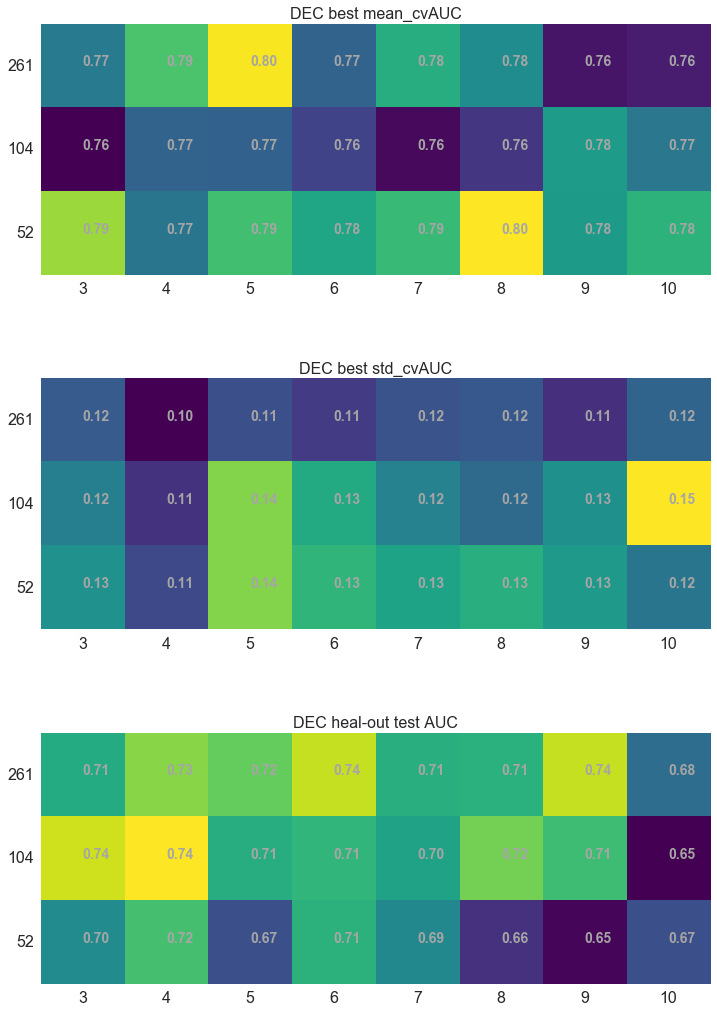

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, FixedLocator, FormatStrFormatter

figscoresM, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18)) 
for k,ax in enumerate(axes.flat):
    im = ax.imshow(scoresM[:,:,k], cmap='viridis', interpolation='nearest')
    ax.grid(False)
    for u in range(len(latent_size)):        
        for v in range(len(varying_mu)):
            ax.text(v,u,'{:.2f}'.format(scoresM[u,v,k]), color=np.array([0.65,0.65,0.65,1]),
                         fontdict={'weight': 'bold', 'size': 14})
    # set ticks
    ax.xaxis.set_major_locator(FixedLocator(np.linspace(0,9,10)))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    
    mu_labels = [str(mu) for mu in varying_mu]
    ax.set_xticklabels(mu_labels, minor=False,fontsize=16)
    ax.yaxis.set_major_locator(FixedLocator(np.linspace(0,2,3)))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    
    znum_labels = [str(znum) for znum in latent_size]
    ax.set_yticklabels(znum_labels, minor=False,fontsize=16)
    ax.xaxis.set_label('Zspace dim')
    ax.yaxis.set_label('# clusters')
    ax.set_title(scoresM_titles[k],fontsize=16)

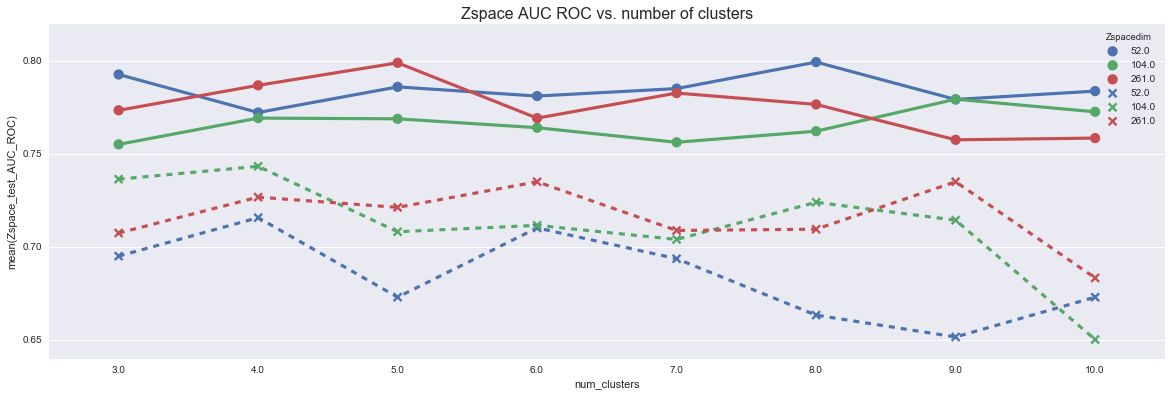

In [23]:
## plot line plots
dict_aucZlatent = pd.DataFrame() 
for k,znum in enumerate(latent_size):
    for l,num_c in enumerate(varying_mu):
        dict_aucZlatent = dict_aucZlatent.append( pd.Series({'Zspacedim':znum, 
                                                             'Zspace_AUC_ROC': scoresM[k,l,0], 
                                                              'Zspace_test_AUC_ROC': scoresM[k,l,2], 
                                                             'num_clusters':num_c}), ignore_index=True)
    
fig2 = plt.figure(figsize=(20,6))
ax2 = plt.axes()
sns.set_context("notebook")  
sns.pointplot(x="num_clusters", y="Zspace_AUC_ROC", hue="Zspacedim", data=dict_aucZlatent, ax=ax2, size=0.05) 
sns.pointplot(x="num_clusters", y="Zspace_test_AUC_ROC", hue="Zspacedim", data=dict_aucZlatent, ax=ax2, size=0.05, markers=["x","x","x"],linestyles=["--","--","--"]) 
ax2.xaxis.set_label('# clusters')
ax2.yaxis.set_label('Zspace AUC ROC')
ax2.set_title('Zspace AUC ROC vs. number of clusters',fontsize=16)
